In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="ticks", rc={'figure.figsize':(9,8)})
sns.set_context(rc = {"font.size":15, "axes.labelsize":15}, font_scale=2)
sns.set_palette('colorblind');
from pandas.api.types import CategoricalDtype


from scipy.stats import pearsonr

# pandas defaults
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

## Loading Dataset

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print("Training data shape: ", train.shape)
print("Testing data shape: ", test.shape)

Training data shape:  (1460, 81)
Testing data shape:  (1459, 80)


In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Removing outliers

In [4]:
train.drop(train[train['LotFrontage']>300].index, inplace = True)
train.drop(train[train['LotArea']>100000].index, inplace = True)
train.drop(train[train['MasVnrArea']>1200].index, inplace = True)
train.drop(train[train['BsmtFinSF1']>3000].index, inplace = True)
train.drop(train[train['TotalBsmtSF']>6000].index, inplace = True)
train.drop(train[train['1stFlrSF']>4000].index, inplace = True)
train.drop(train[train['GrLivArea']>4000].index, inplace = True)
train.drop(train[train['EnclosedPorch']>800].index, inplace = True)
train.drop(train[train['MiscVal']>8000].index, inplace = True)

In [5]:
train.shape

(1447, 81)

## 1. Variable identification
SalePrice is the target variable and the rest are the predcitor variable.

In [6]:
global measure_columns_spread_df, list_of_columns_with_null_values
list_of_columns_with_null_values = []
measure_columns_spread_df = pd.DataFrame(columns = ['col_name', 'skewness', 'kurtosis', 'transformation_reqd', 'null_values'])
def collect_calculate_col_spread(df, col):
    global measure_columns_spread_df
    temp = pd.DataFrame(pd.Series([col, df[col].skew(), df[col].kurt(), np.nan, np.nan])).T
    temp.columns = ['col_name', 'skewness', 'kurtosis', 'transformation_reqd', 'null_values']
    condition = (df[col].skew() < -1) | (df[col].skew() > 1) | (df[col].kurt() < -1) | ((df[col].kurt() > 1))
    temp.loc[0,'transformation_reqd']=np.where(condition, 'Yes', 'No')
    temp.loc[0, 'null_values'] = np.where(df[col].isnull().sum(), 'Present', 'Absent')
    if (df[col].isnull().sum()):
        list_of_columns_with_null_values.append(col)
    print("Count of null values in train dataset: ", df[col].isnull().sum())
    measure_columns_spread_df = pd.concat([measure_columns_spread_df, temp], ignore_index = True)
    
    
def univariate_numerical_analysis(df, col):
    collect_calculate_col_spread(df, col)
    fig, axs = plt.subplots(2,1, figsize = (10,9));
    sns.distplot(train[col], ax = axs[0]);
    axs[0].set_title("Histogram of " + col);
    axs[1].set_title("Boxplot of " + col);
    sns.boxplot(train[col], ax = axs[1]);
    title=("Skewness of {}: ".format(col) + "{0:.2f}".format(train[col].skew()) + " and " + "Kurtosis of {}: ".format(col) 
           +"{0:.2f}".format(train[col].kurt()))
    fig.suptitle(title, y = 1.01);
    plt.tight_layout(); 
    plt.show();

Count of null values in train dataset:  0


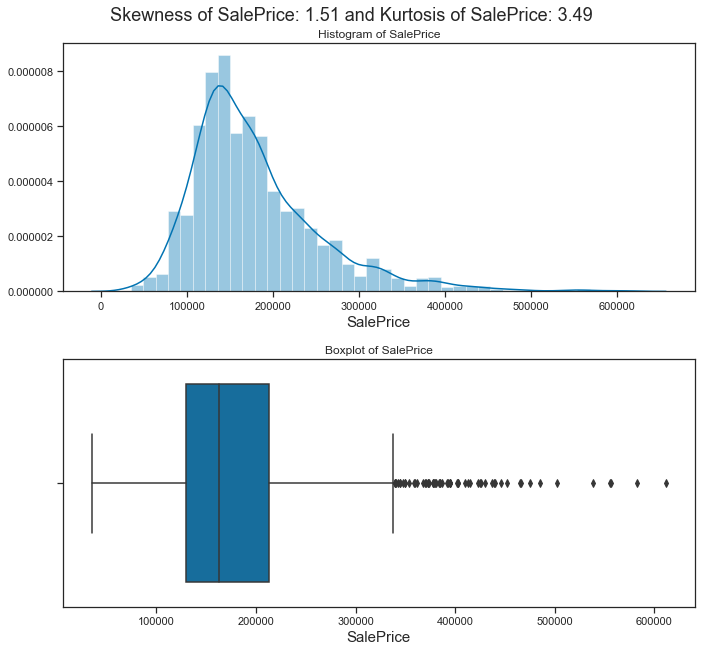

In [7]:
univariate_numerical_analysis(train, 'SalePrice')

## Combining train and test set into one dataset for easir data wrangling

In [8]:
train['SalePrice_Log'] = np.log(train['SalePrice'])
train.drop(columns = 'SalePrice', inplace = True)

In [9]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice_Log
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,12.247694
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,12.109011
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,12.317167
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,11.849398
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,12.429216


#### rbinding train and test data

In [10]:
data = pd.concat([train.drop(columns='SalePrice_Log'), test], axis = 0)
data.shape

(2906, 80)

In [11]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [12]:
data.drop(columns = ['Id', 'BsmtFinSF2'], inplace = True)

In [13]:
data.isnull().sum()[data.isnull().sum()!=0]

MSZoning           4
LotFrontage      481
Alley           2709
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1419
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2898
Fence           2336
MiscFeature     2805
SaleType           1
dtype: int64

Filling NA values of numerical columns

In [14]:
for col in ['BsmtHalfBath','BsmtFullBath']:
    data[col] = data[col].fillna(data[col].value_counts().idxmax())

In [15]:
data['GarageYrBlt'] = data['GarageYrBlt'].fillna(0)

In [16]:
for col in ['LotFrontage', 'MasVnrArea']:
    data[col] = data[col].fillna(data[col].median())

In [17]:
for col in ['BsmtFinSF1','BsmtUnfSF','TotalBsmtSF','GarageCars','GarageArea']:
    data[col] = data[col].fillna(data[col].median())

Filling NA values of object/categorical columns

In [18]:
for col in ['MasVnrType', 'Electrical']:
    data[col] = data[col].fillna(data[col].value_counts().idxmax())

In [19]:
for col in ['Alley', 'GarageType', 'GarageFinish', 'BsmtQual', 'BsmtCond', 'BsmtExposure',  'BsmtFinType1', 'PoolQC',
            'BsmtFinType2', 'FireplaceQu', 'GarageQual',  'GarageCond','Fence', 'MiscFeature']:
    data[col] = data[col].fillna('None')

In [20]:
data['MSZoning'] = data['MSZoning'].fillna(data['MSZoning'].value_counts().index[0])
data['Utilities'] = data['Utilities'].fillna(data['Utilities'].value_counts().index[0])
data['GarageCond'] = data['GarageCond'].fillna('None')
data['SaleType'] = data['SaleType'].fillna(data['SaleType'].value_counts().index[0])
data['Functional'] = data['Functional'].fillna(data['Functional'].value_counts().index[0])
data['KitchenQual'] = data['KitchenQual'].fillna(data['KitchenQual'].value_counts().index[0])
data['Exterior1st'] = data['Exterior1st'].fillna(data['Exterior1st'].value_counts().index[0])
data['Exterior2nd'] = data['Exterior2nd'].fillna(data['Exterior2nd'].value_counts().index[0])

In [21]:
data.isnull().sum()[data.isnull().sum()!=0]

Series([], dtype: int64)

So NA values of all columns are filled.

***

# Need to check these transformations

In [22]:
# to check for presence of zero in each columns as log(0) is undefined and will cause error
def count_check_zeros(t):
    return(sum(t==0))
        
data[['GrLivArea', '1stFlrSF', 'LotArea', 'LotFrontage']].apply(count_check_zeros, axis = 0)

GrLivArea      0
1stFlrSF       0
LotArea        0
LotFrontage    0
dtype: int64

In [23]:
for col in ['GrLivArea', '1stFlrSF', 'LotArea', 'LotFrontage']:
    data[col+'_Log'] = np.log(train[col])
    data.drop(columns = col, inplace = True)

Check presence of null values again

In [24]:
data.isnull().sum()[data.isnull().sum()!=0]

GrLivArea_Log       13
1stFlrSF_Log        13
LotArea_Log         13
LotFrontage_Log    521
dtype: int64

In [25]:
data['LotFrontage_Log'] = data['LotFrontage_Log'].fillna(data['LotFrontage_Log'].median())

In [26]:
data['GrLivArea_Log'] = data['GrLivArea_Log'].fillna(data['GrLivArea_Log'].median())
data['1stFlrSF_Log'] = data['1stFlrSF_Log'].fillna(data['1stFlrSF_Log'].median())
data['LotArea_Log'] = data['LotArea_Log'].fillna(data['LotArea_Log'].median())


### Dealing with all object/category type columns

Converting object columns to ordinal category type

In [27]:
cat_type = CategoricalDtype(['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered=True)
for col in ['BsmtQual', 'BsmtCond', 'FireplaceQu', 'GarageQual']:
    data[col] = data[col].astype(cat_type)
    
cat_type = CategoricalDtype(['IR3', 'IR2', 'IR1', 'Reg'], ordered=True)
data['LotShape'] = data['LotShape'].astype(cat_type)

cat_type = CategoricalDtype(['None', 'Fa', 'TA', 'Gd', 'Ex'], ordered=True)
data['PoolQC'] = data['PoolQC'].astype(cat_type)

cat_type = CategoricalDtype(['None', 'No', 'Mn', 'Av', 'Gd'], ordered=True)
data['BsmtExposure'] = data['BsmtExposure'].astype(cat_type)

cat_type = CategoricalDtype(['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], ordered=True)
for col in ['BsmtFinType2', 'BsmtFinType1']:
    data[col] = data[col].astype(cat_type)

In [28]:
cat_type = CategoricalDtype(['None', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'], ordered=True)
data['Fence'] = data['Fence'].astype(cat_type)

In [29]:
cat_type = CategoricalDtype(['Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered=True)
data['KitchenQual'] = data['KitchenQual'].astype(cat_type)
data['HeatingQC'] = data['HeatingQC'].astype(cat_type)

In [30]:
cat_type = CategoricalDtype(['Low', 'HLS', 'Bnk', 'Lvl'], ordered=True)
data['LandContour'] = data['LandContour'].astype(cat_type)

In [31]:
cat_type = CategoricalDtype(['ELO', 'NoSeWa', 'NoSewr', 'AllPub'], ordered=True)
data['Utilities'] = data['Utilities'].astype(cat_type)

In [32]:
cat_type = CategoricalDtype(['Sev', 'Mod', 'Gtl'], ordered=True)
data['LandSlope'] = data['LandSlope'].astype(cat_type)

In [33]:
cat_type = CategoricalDtype(['Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered=True)
for col in ['ExterQual', 'ExterCond']:
    data[col] = data[col].astype(cat_type)

In [34]:
cat_type = CategoricalDtype(['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],ordered=True)
data['Functional'] = data['Functional'].astype(cat_type)

In [35]:
cat_type = CategoricalDtype(['None', 'Detchd', 'CarPort', 'BuiltIn', 'Basment', 'Attchd', '2Types'],ordered=True)
data['GarageType'] = data['GarageType'].astype(cat_type)

In [36]:
cat_type = CategoricalDtype(['None', 'Unf', 'RFn', 'Fin'],ordered=True)
data['GarageFinish'] = data['GarageFinish'].astype(cat_type)

In [37]:
cat_type = CategoricalDtype(['N', 'P', 'Y'],ordered=True)
data['PavedDrive'] = data['PavedDrive'].astype(cat_type)

In [38]:
data.shape

(2906, 78)

In [39]:
data.select_dtypes(include=['object']).dtypes.index

Index(['MSZoning', 'Street', 'Alley', 'LotConfig', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
       'Heating', 'CentralAir', 'Electrical', 'GarageCond', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

This dictionary will be helpful while creating one-hot encoder.

Removing any duplicate rows

In [40]:
data.shape

(2906, 78)

Create datas for train and test set make sure to use the copy() function

In [41]:
X_train = data.iloc[:len(train),:].copy()
X_test = data.iloc[len(train):,:].copy()

In [42]:
X_train = pd.concat([X_train,train['SalePrice_Log']], axis = 1)

### Data wrangling after bivariate analysis

After doing ANOVA its found that some categorical columns do not have any impact on the target variable so dropping them

In [43]:
X_train.drop(columns = ['Street', 'Utilities', 'LandSlope', 'PoolQC', 'MiscFeature'], inplace = True)
X_test.drop(columns = ['Street', 'Utilities', 'LandSlope', 'PoolQC', 'MiscFeature'], inplace = True)

In [44]:
X_train.shape

(1447, 74)

In [45]:
X_test.shape

(1459, 73)

In [46]:
X_train.head()

,MSSubClass,MSZoning,Alley,LotShape,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,GrLivArea_Log,1stFlrSF_Log,LotArea_Log,LotFrontage_Log,SalePrice_Log
0,60,RL,None,Reg,Lvl,Inside,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,150.0,856.0,GasA,Ex,Y,SBrkr,854,0,1.0,0.0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,None,0,2,2008,WD,Normal,7.444249,6.752270,9.041922,4.174387,12.247694
1,20,RL,None,Reg,Lvl,FR2,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,284.0,1262.0,GasA,Ex,Y,SBrkr,0,0,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,None,0,5,2007,WD,Normal,7.140453,7.140453,9.169518,4.382027,12.109011
2,60,RL,None,IR1,Lvl,Inside,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,434.0,920.0,GasA,Ex,Y,SBrkr,866,0,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,None,0,9,2008,WD,Normal,7.487734,6.824374,9.328123,4.219508,12.317167
3,70,RL,None,IR1,Lvl,Corner,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,540.0,756.0,GasA,Gd,Y,SBrkr,756,0,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,None,0,2,2006,WD,Abnorml,7.448334,6.867974,9.164296,4.094345,11.849398
4,60,RL,None,IR1,Lvl,FR2,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,490.0,1145.0,GasA,Ex,Y,SBrkr,1053,0,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,None,0,12,2008,WD,Normal,7.695303,7.043160,9.565214,4.430817,12.429216


Converting ordinal category type columns into ordinal encoded types

In [47]:
len(X_train.select_dtypes(include='category').columns)

18

In [48]:
for col in X_train.select_dtypes(include='category').columns:
    X_train[col] = X_train[col].cat.codes

In [49]:
X_train.head()

,MSSubClass,MSZoning,Alley,LotShape,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,GrLivArea_Log,1stFlrSF_Log,LotArea_Log,LotFrontage_Log,SalePrice_Log
0,60,RL,None,3,3,Inside,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,3,2,PConc,4,3,1,6,706.0,1,150.0,856.0,GasA,4,Y,SBrkr,854,0,1.0,0.0,2,1,3,1,3,8,7,0,0,5,2003.0,2,2.0,548.0,3,TA,2,0,61,0,0,0,0,0,0,2,2008,WD,Normal,7.444249,6.752270,9.041922,4.174387,12.247694
1,20,RL,None,3,3,FR2,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,2,2,CBlock,4,3,4,5,978.0,1,284.0,1262.0,GasA,4,Y,SBrkr,0,0,0.0,1.0,2,0,3,1,2,6,7,1,3,5,1976.0,2,2.0,460.0,3,TA,2,298,0,0,0,0,0,0,0,5,2007,WD,Normal,7.140453,7.140453,9.169518,4.382027,12.109011
2,60,RL,None,2,3,Inside,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,3,2,PConc,4,3,2,6,486.0,1,434.0,920.0,GasA,4,Y,SBrkr,866,0,1.0,0.0,2,1,3,1,3,6,7,1,3,5,2001.0,2,2.0,608.0,3,TA,2,0,42,0,0,0,0,0,0,9,2008,WD,Normal,7.487734,6.824374,9.328123,4.219508,12.317167
3,70,RL,None,2,3,Corner,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,2,2,BrkTil,3,4,1,5,216.0,1,540.0,756.0,GasA,3,Y,SBrkr,756,0,1.0,0.0,1,0,3,1,3,7,7,1,4,1,1998.0,1,3.0,642.0,3,TA,2,0,35,272,0,0,0,0,0,2,2006,WD,Abnorml,7.448334,6.867974,9.164296,4.094345,11.849398
4,60,RL,None,2,3,FR2,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,3,2,PConc,4,3,3,6,655.0,1,490.0,1145.0,GasA,4,Y,SBrkr,1053,0,1.0,0.0,2,1,4,1,3,9,7,1,3,5,2000.0,2,3.0,836.0,3,TA,2,192,84,0,0,0,0,0,0,12,2008,WD,Normal,7.695303,7.043160,9.565214,4.430817,12.429216


In [50]:
numeric_dtypes = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_columns = list(X_train.select_dtypes(include = numeric_dtypes).columns)
numerical_columns[:6]

['MSSubClass',
 'LotShape',
 'LandContour',
 'OverallQual',
 'OverallCond',
 'YearBuilt']

In [51]:
len(numerical_columns)

54

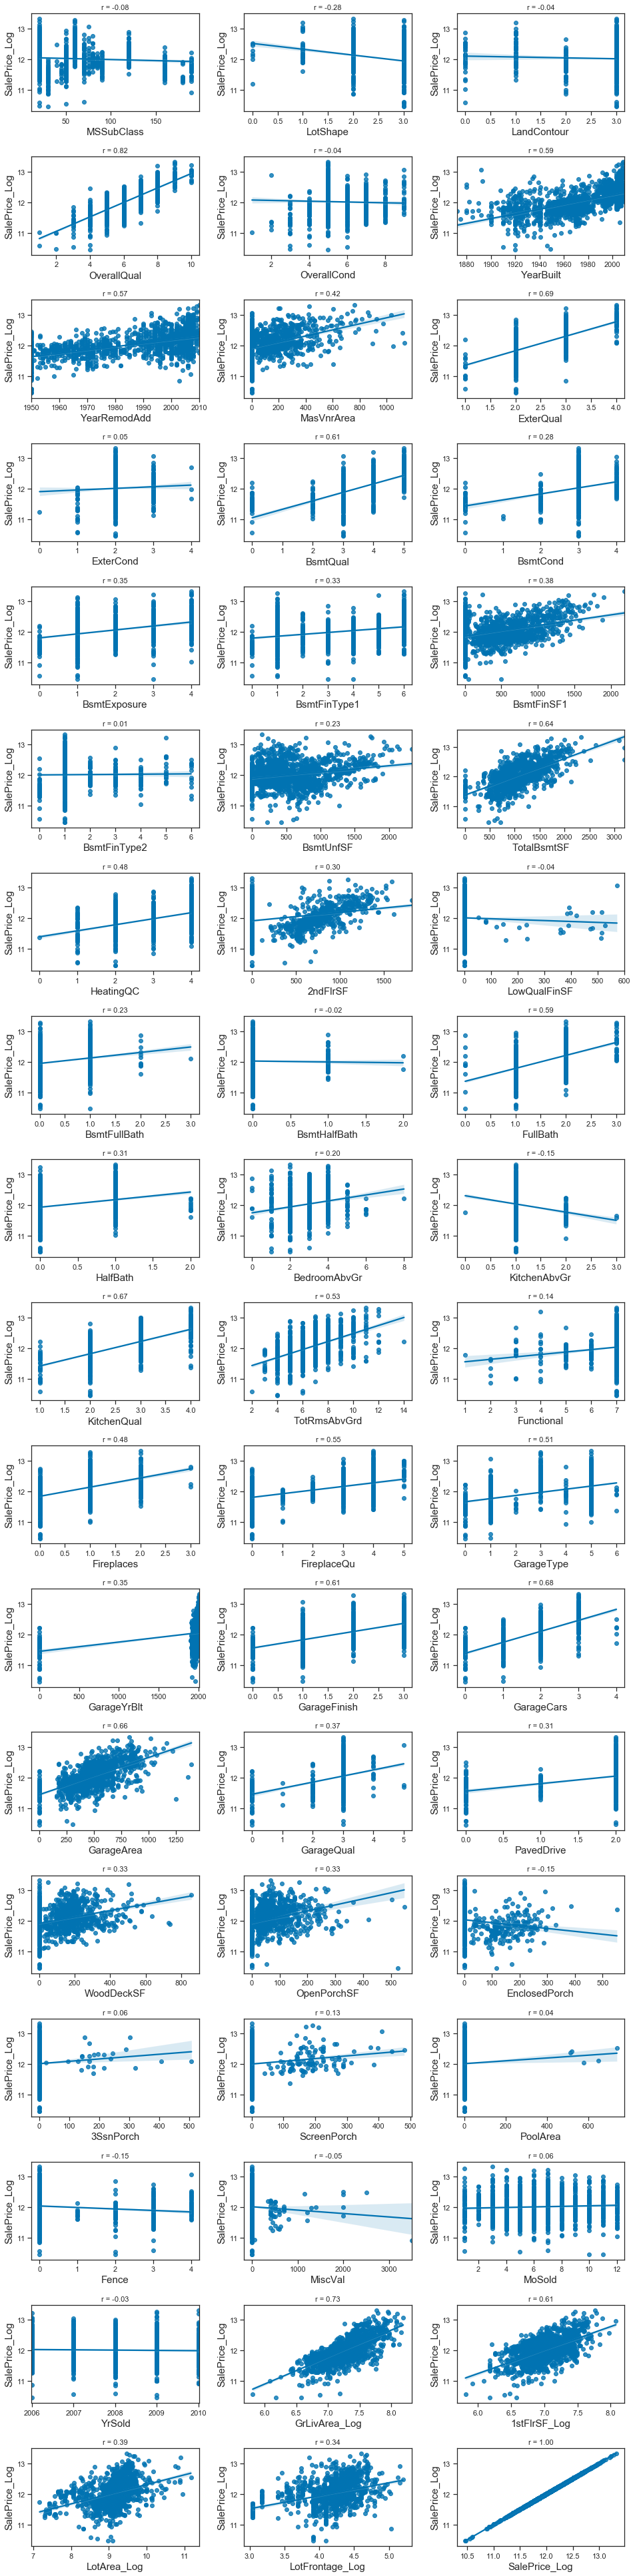

In [52]:
correlation_results_list = []
nrows = 18
ncols = 3
fig, axes = plt.subplots(nrows,ncols, figsize=(ncols*4.5,nrows*3))
axes_list = [item for sublist in axes for item in sublist] 
for col in numerical_columns:
    ax = axes_list.pop(0) # Take the first axes of the axes_list
    sns.regplot(X_train[col], X_train['SalePrice_Log'], ax = ax)
    stp = pearsonr(X_train[col], X_train['SalePrice_Log'])
    str_title = "r = " + "{0:.2f}".format(stp[0])
    ax.set_title(str_title,fontsize=11)
    correlation_results_list.append((col, abs(stp[0])))
    
plt.tight_layout(); 
plt.show();

In [53]:
correlation_df = pd.DataFrame(correlation_results_list, columns = ['column_name', 'correlation'])
correlation_df

,column_name,correlation
0,MSSubClass,0.075444
1,LotShape,0.275424
2,LandContour,0.043290
3,OverallQual,0.820201
4,OverallCond,0.036169
5,YearBuilt,0.592433
6,YearRemodAdd,0.572441
7,MasVnrArea,0.424985
8,ExterQual,0.686101
9,ExterCond,0.047364


In [54]:
correlation_df[correlation_df['correlation']>=0.5]

,column_name,correlation
3,OverallQual,0.820201
5,YearBuilt,0.592433
6,YearRemodAdd,0.572441
8,ExterQual,0.686101
10,BsmtQual,0.614435
17,TotalBsmtSF,0.639294
23,FullBath,0.587314
27,KitchenQual,0.670888
28,TotRmsAbvGrd,0.533500
31,FireplaceQu,0.545423


Columns to be deleted from train/test/X_train dataset which have very low correlation.

In [55]:
for col in correlation_df['column_name'][correlation_df['correlation']<0.5]:
    X_test.drop(columns = col, inplace = True)
    X_train.drop(columns = col, inplace = True)
    data.drop(columns = col, inplace = True)

In [56]:
X_train.shape

(1447, 37)

In [57]:
X_test.shape

(1459, 36)

In [58]:
data.shape

(2906, 41)

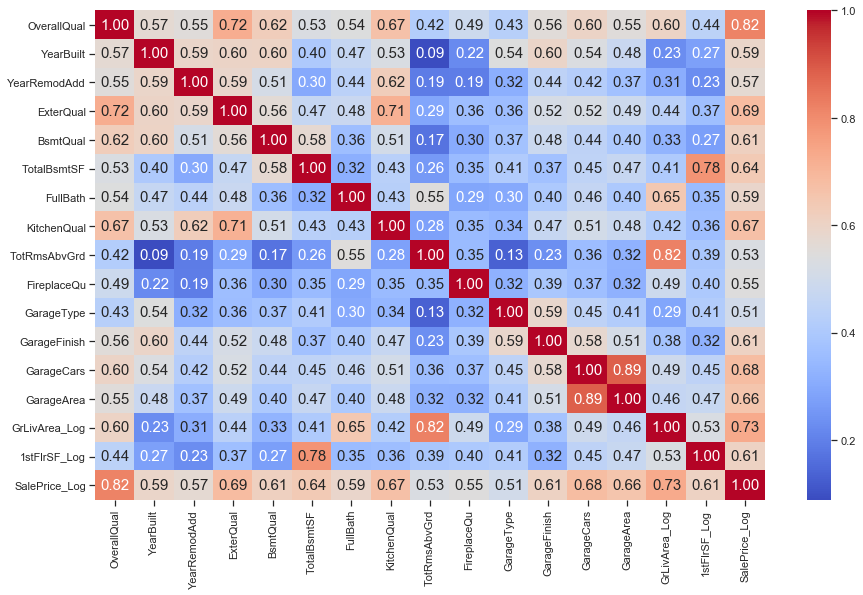

In [59]:
plt.figure(figsize=(15,9))
sns.heatmap(X_train.corr(), annot=True, fmt = '.2f', cmap='coolwarm');

Dropping columns having high value of correlation to avoid multicolinearity
Columns with high correlation i.e., more than 0.8:

- 1stFlrSF_Log and TotalBsmtSF
- GrLivArea_Log and TotRmsAbvGrd
- GarageArea and GarageCars
- KitchenQual and ExterQual


In [60]:
X_train.columns.sort_values()

Index(['1stFlrSF_Log', 'Alley', 'BldgType', 'BsmtQual', 'CentralAir',
       'Condition1', 'Condition2', 'Electrical', 'ExterQual', 'Exterior1st',
       'Exterior2nd', 'FireplaceQu', 'Foundation', 'FullBath', 'GarageArea',
       'GarageCars', 'GarageCond', 'GarageFinish', 'GarageType',
       'GrLivArea_Log', 'Heating', 'HouseStyle', 'KitchenQual', 'LotConfig',
       'MSZoning', 'MasVnrType', 'Neighborhood', 'OverallQual', 'RoofMatl',
       'RoofStyle', 'SaleCondition', 'SalePrice_Log', 'SaleType',
       'TotRmsAbvGrd', 'TotalBsmtSF', 'YearBuilt', 'YearRemodAdd'],
      dtype='object')

In [61]:
for col in ['TotalBsmtSF', 'TotRmsAbvGrd', 'GarageCars', 'ExterQual']:
    X_train.drop(columns = col, inplace = True)
    X_test.drop(columns = col, inplace = True)
    data.drop(columns = col, inplace = True)

Trying to find association between the nominal category columns

In [62]:
global categ_columns_with_high_association, categ_columns_with_low_association
categ_columns_with_high_association = []
categ_columns_with_low_association = []
def perform_anova_and_its_results(categ_col, num_col='SalePrice_Log', df = X_train):
    
    from scipy.stats import f
    import statsmodels.api as sm
    from statsmodels.formula.api import ols
    
    df_sst = len(df[num_col])-1
    df_ssb = df[categ_col].nunique() - 1
    df_ssw = df_sst - df_ssb
    F_critical = f.ppf(0.95, df_ssb, df_ssw)
    print("F_Critical: {0:.3f}".format(F_critical))
    results = ols('{} ~{}'.format(num_col, categ_col), data = train).fit()
    aov_table = sm.stats.anova_lm(results, typ = 1)  
    F_stat = aov_table.loc[categ_col, 'F']
    print("F_statistic: {0:.3f}".format(F_stat))
    if (F_stat > F_critical):
        print("F-statistic is more than F-critical")
        print("There is an association between {} and {}".format(categ_col,num_col))
        categ_columns_with_high_association.append(categ_col)
    else:
        print("F-statistic is less than F-critical")
        print("There is no association between {} and {}".format(categ_col,num_col))
        categ_columns_with_low_association.append(categ_col)
    print('-'*30)

In [63]:
for col in X_train.select_dtypes(include = 'object').columns:
    perform_anova_and_its_results(col)

F_Critical: 2.378
F_statistic: 78.019
F-statistic is more than F-critical
There is an association between MSZoning and SalePrice_Log
------------------------------
F_Critical: 3.002
F_statistic: 25.289
F-statistic is more than F-critical
There is an association between Alley and SalePrice_Log
------------------------------
F_Critical: 2.378
F_statistic: 7.655
F-statistic is more than F-critical
There is an association between LotConfig and SalePrice_Log
------------------------------
F_Critical: 1.525
F_statistic: 78.454
F-statistic is more than F-critical
There is an association between Neighborhood and SalePrice_Log
------------------------------
F_Critical: 1.945
F_statistic: 8.035
F-statistic is more than F-critical
There is an association between Condition1 and SalePrice_Log
------------------------------
F_Critical: 2.105
F_statistic: 3.264
F-statistic is more than F-critical
There is an association between Condition2 and SalePrice_Log
------------------------------
F_Critical: 2

In [64]:
categ_columns_with_low_association

[]

In [65]:
categ_columns_with_high_association

['MSZoning',
 'Alley',
 'LotConfig',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'Foundation',
 'Heating',
 'CentralAir',
 'Electrical',
 'GarageCond',
 'SaleType',
 'SaleCondition']

So all the nominal columns have high association with SalePrice_Log.

In [66]:
X_train.shape

(1447, 33)

In [67]:
X_test.shape

(1459, 32)

In [68]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer, OneHotEncoder,OrdinalEncoder

In [69]:
temp = X_train.select_dtypes(include=numeric_dtypes).columns.to_list()
temp.remove('SalePrice_Log')

In [70]:
train_updated = data.iloc[:len(train),:].copy()
test_updated = data.iloc[len(train):,:].copy()

In [71]:
train_updated = pd.concat([train_updated,X_train['SalePrice_Log']], axis = 1)
train_updated.shape

(1447, 38)

In [72]:
test_updated.shape

(1459, 37)

In [73]:
X = train_updated.loc[:,train_updated.columns[train_updated.columns!='SalePrice_Log']]
y = train_updated['SalePrice_Log'].copy()

In [74]:
X.head()

,MSZoning,Street,Alley,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,BsmtQual,Heating,CentralAir,Electrical,FullBath,KitchenQual,FireplaceQu,GarageType,GarageFinish,GarageArea,GarageCond,PoolQC,MiscFeature,SaleType,SaleCondition,GrLivArea_Log,1stFlrSF_Log
0,RL,Pave,None,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,Gd,GasA,Y,SBrkr,2,Gd,None,Attchd,RFn,548.0,TA,None,None,WD,Normal,7.444249,6.752270
1,RL,Pave,None,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,CBlock,Gd,GasA,Y,SBrkr,2,TA,TA,Attchd,RFn,460.0,TA,None,None,WD,Normal,7.140453,7.140453
2,RL,Pave,None,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,Gd,GasA,Y,SBrkr,2,Gd,TA,Attchd,RFn,608.0,TA,None,None,WD,Normal,7.487734,6.824374
3,RL,Pave,None,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,BrkTil,TA,GasA,Y,SBrkr,1,Gd,Gd,Detchd,Unf,642.0,TA,None,None,WD,Abnorml,7.448334,6.867974
4,RL,Pave,None,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,Gd,GasA,Y,SBrkr,2,Gd,TA,Attchd,RFn,836.0,TA,None,None,WD,Normal,7.695303,7.043160


In [75]:
ohe_dict_cols = {}
for col in data.select_dtypes(include=['object']).dtypes.index:
    ohe_dict_cols[col] = pd.Series(data[col].unique()).to_list()

In [89]:
import pprint
# pprint.pprint(ohe_dict_cols)

In [91]:
# For one-hot encoder
t_k = []
t_v = []
for k,v in ohe_dict_cols.items():
    t_k.append(k)
    t_v.append(v)

# pprint.pprint(t_k)    
# pprint.pprint(t_v)    

In [77]:
len(X.select_dtypes(include='category').columns)

8

In [92]:
ord_encod_dict = {}
for col in X.select_dtypes(include='category').columns:
    ord_encod_dict[col] = pd.Series(data[col].unique().sort_values()).to_list()

In [93]:
# For ordinal encoder
ordinal_cols = []
ordinal_vals = []
for k,v in ord_encod_dict.items():
    ordinal_cols.append(k)
    ordinal_vals.append(v)

In [80]:
len(X.select_dtypes(include='object').columns)

22

In [81]:
len(X.select_dtypes(include=numeric_dtypes).columns)

7

In [112]:
num_cols = X.columns[~X.columns.isin(t_k + ordinal_cols)].to_list()
num_cols

['OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'FullBath',
 'GarageArea',
 'GrLivArea_Log',
 '1stFlrSF_Log']

In [113]:
colT = ColumnTransformer([
    ('dummy_col',OneHotEncoder(drop = 'first',categories = t_v), t_k),
    ('norm', Normalizer(norm='l1'), num_cols),
    ('ordinal_col', OrdinalEncoder(categories = ordinal_vals), ordinal_cols)
], remainder = 'passthrough')

In [83]:
from sklearn.model_selection import cross_val_score,KFold

In [84]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

- To see the valid scoring values to be used in cross validation: [check this link](https://scikit-learn.org/stable/modules/model_evaluation.html)
- And to see the valid metrics that can be used here use the following code:
```
import sklearn
sorted(sklearn.metrics.SCORERS.keys())
```

### Linear regression

In [114]:
from time import time
from sklearn.linear_model  import LinearRegression
lin_reg = LinearRegression()

pipeline = Pipeline(steps = [("colt", colT), ("regl",lin_reg)])
param_grid = {"regl__fit_intercept":[True,False]}

grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = 10, scoring = 'neg_root_mean_squared_error')

t0 = time()
grid.fit(X, y)
print("training time: {}s".format(round(time()-t0, 3)))

# best algorithm
reg = grid.best_estimator_

t0 = time()
prediction = reg.predict(test_updated)
print("testing time: {}s".format(round(time()-t0, 3)))


print("Best gird parameters : ", grid.best_params_)
print("RMSE: ", np.sqrt(-grid.best_score_))

training time: 3.487s
testing time: 0.028s
Best gird parameters :  {'regl__fit_intercept': True}
RMSE:  0.3874697109442707


[return coefficients from Pipeline object in sklearn](https://stackoverflow.com/questions/43856280/return-coefficients-from-pipeline-object-in-sklearn)

> __named_steps__ : dict - Read-only attribute to access any step parameter by user given name. Keys are step names and values are steps parameters.

To get the value of itercept used in the above linear regression

In [115]:
reg.named_steps['regl'].intercept_

169.15954721391185

To get the value of coefficents assigned to each feature.

## XGBoost

In [116]:
import xgboost as xgb
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, alpha = 10, n_estimators = 10)

pipeline = Pipeline(steps = [('colt', colT), ("xg", xg_reg)])
param_grid = {"xg__learning_rate": [0.1,0.3,0.5,0.7],
             "xg__max_depth": [2,3,4,5],
             "xg__max_features":['auto', 'sqrt', 'log2']}

grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = 10, scoring = 'neg_root_mean_squared_error')

t0 = time()
grid.fit(X, y)
print("training time: {}s".format(round(time()-t0, 3)))

# best algorithm
reg = grid.best_estimator_

t0 = time()
prediction_XG = reg.predict(test_updated)
print("testing time: {}s".format(round(time()-t0, 3)))
print("Best gird parameters : ", grid.best_params_)
print("RMSE XG: ", np.sqrt(-grid.best_score_))

ModuleNotFoundError: No module named 'xgboost'

## Decision Tree regression

In [117]:
from sklearn.tree import DecisionTreeRegressor
dtreg = DecisionTreeRegressor(random_state=0)

pipeline = Pipeline(steps = [('colt', colT), ("dt", dtreg)])
param_grid = {"dt__splitter": ['best', 'random'],
             "dt__max_depth": [2,3,4,5],
             "dt__max_features":['auto', 'sqrt', 'log2']}

grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = 10, scoring = 'neg_root_mean_squared_error')

t0 = time()
grid.fit(X, y)
print("training time: {}s".format(round(time()-t0, 3)))

# best algorithm
reg = grid.best_estimator_

t0 = time()
prediction_dt = reg.predict(test_updated)
print("testing time: {}s".format(round(time()-t0, 3)))
print("Best gird parameters : ", grid.best_params_)
print("RMSE DT: ", np.sqrt(-grid.best_score_))

training time: 19.314s
testing time: 0.029s
Best gird parameters :  {'dt__max_depth': 5, 'dt__max_features': 'auto', 'dt__splitter': 'best'}
RMSE DT:  0.46007215106320093


### Random Forest Regressor

In [118]:
from sklearn.ensemble import RandomForestRegressor
rfreg = RandomForestRegressor()

pipeline = Pipeline(steps = [('colt', colT), ("rf", rfreg)])
param_grid = {"rf__n_estimators": [10,20,50,100],
             "rf__max_depth": [2,3,4,5],
             "rf__max_features":['auto', 'sqrt', 'log2']}

grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = 10, scoring = 'neg_root_mean_squared_error')

t0 = time()
grid.fit(X, y)
print("training time: {}s".format(round(time()-t0, 3)))

# best algorithm
reg = grid.best_estimator_

t0 = time()
prediction_rf = reg.predict(test_updated)
print("testing time: {}s".format(round(time()-t0, 3)))
print("Best gird parameters : ", grid.best_params_)
print("RMSE RF: ", np.sqrt(-grid.best_score_))

training time: 106.884s
testing time: 0.044s
Best gird parameters :  {'rf__max_depth': 5, 'rf__max_features': 'auto', 'rf__n_estimators': 100}
RMSE RF:  0.42339924595392436


### Ridge regression

In [119]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge()

pipeline = Pipeline(steps = [('colt', colT), ("ridge", ridge_reg)])
param_grid = {"ridge__alpha": [0.05, 0.07, 0.08, 0.095,1,1.5],
             "ridge__fit_intercept": [True, False]}

grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = 10, scoring = 'neg_root_mean_squared_error')

t0 = time()
grid.fit(X, y)
print("training time: {}s".format(round(time()-t0, 3)))

# best algorithm
reg = grid.best_estimator_

t0 = time()
prediction_ridge = reg.predict(test_updated)
print("testing time: {}s".format(round(time()-t0, 3)))
print("Best gird parameters : ", grid.best_params_)
print("RMSE Ridge: ", np.sqrt(-grid.best_score_))

training time: 8.524s
testing time: 0.026s
Best gird parameters :  {'ridge__alpha': 1, 'ridge__fit_intercept': True}
RMSE Ridge:  0.4104327504000314


### Lasso regression

In [120]:
from sklearn.linear_model import Lasso
lasso_reg = Ridge()

pipeline = Pipeline(steps = [('colt', colT), ("lasso", lasso_reg)])
param_grid = {"lasso__alpha": [0.05,1,1.5,2],
             "lasso__fit_intercept": [True, False]}

grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = 10, scoring = 'neg_root_mean_squared_error')

t0 = time()
grid.fit(X, y)
print("training time: {}s".format(round(time()-t0, 3)))

# best algorithm
reg = grid.best_estimator_

t0 = time()
prediction_lassso = reg.predict(test_updated)
print("testing time: {}s".format(round(time()-t0, 3)))
print("Best gird parameters : ", grid.best_params_)
print("RMSE Lasso: ", np.sqrt(-grid.best_score_))

training time: 5.336s
testing time: 0.027s
Best gird parameters :  {'lasso__alpha': 1, 'lasso__fit_intercept': True}
RMSE Lasso:  0.4104327504000314


### Elastic Net regression

In [121]:
from sklearn.linear_model import ElasticNet
elastic_reg = ElasticNet()

pipeline = Pipeline(steps = [('colt', colT), ("elastic", elastic_reg)])
param_grid = {"elastic__alpha": [0.05,0.07,1,1.5,2],
             "elastic__fit_intercept": [True, False],
             "elastic__l1_ratio":[.025,0.05, 0.07,0.08, 0.095]}

grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = 10, scoring = 'neg_root_mean_squared_error')

t0 = time()
grid.fit(X, y)
print("training time: {}s".format(round(time()-t0, 3)))

# best algorithm
reg = grid.best_estimator_

t0 = time()
prediction_elastic = reg.predict(test_updated)
print("testing time: {}s".format(round(time()-t0, 3)))
print("Best gird parameters : ", grid.best_params_)
print("RMSE elastic: ", np.sqrt(-grid.best_score_))

training time: 36.135s
testing time: 0.027s
Best gird parameters :  {'elastic__alpha': 0.05, 'elastic__fit_intercept': True, 'elastic__l1_ratio': 0.025}
RMSE elastic:  0.4419771082923736


## SVR

In [ ]:
from sklearn.svm import SVR
svr = SVR()

pipeline = Pipeline(steps = [('colt', colT), ("svrpara", svr)])
param_grid = {"svrpara__kernel": ['rbf', 'linear', 'poly', 'sigmoid'],
             "svrpara__degree": [2,3,4],
             "svrpara__gamma": ['scale', 'auto'],
             "svrpara__C":[0.5,0.8,1],
             "svrpara__epsilon":[0.08,0.1,0.15,0.2]}

grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = 10, scoring = 'neg_root_mean_squared_error')

t0 = time()
grid.fit(X, y)
print("training time: {}s".format(round(time()-t0, 3)))

# best algorithm
reg = grid.best_estimator_

t0 = time()
prediction_svr = reg.predict(test_updated)
print("testing time: {}s".format(round(time()-t0, 3)))
print("Best gird parameters : ", grid.best_params_)
print("RMSE SVR: ", np.sqrt(-grid.best_score_))

In [122]:
sub_pred = np.exp(prediction)

In [123]:
df_output = pd.DataFrame()
df_output['Id'] = test['Id']
df_output['SalePrice'] = sub_pred
df_output.head()

,Id,SalePrice
0,1461,140786.076136
1,1462,152777.683217
2,1463,166016.171896
3,1464,186832.377361
4,1465,210945.290063


In [124]:
df_output.to_csv('submission_3.csv', index = False)